### Imports

In [1]:
import pandas as pd
import warnings
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from pathlib import Path
import sys
from sklearn.model_selection import StratifiedKFold, train_test_split

warnings.filterwarnings("ignore")
pd.options.display.max_columns = 100

In [2]:
%load_ext watermark

In [3]:
%watermark -p pandas,numpy,plotly,seaborn

pandas : 2.2.2
numpy  : 1.24.3
plotly : 5.22.0
seaborn: 0.13.2



In [4]:
%load_ext autoreload
%autoreload 2

In [5]:
sys.path.insert(0, str(Path.cwd().parent.joinpath("src/")))

In [6]:
from config import Settings
from utils import lgb_cv, evaluate_model

In [7]:
config = Settings()

### Read data

In [8]:
df = pd.read_csv(config.data_path)
df.columns = df.columns.str.strip().tolist()

In [9]:
df.shape

(4269, 13)

In [10]:
cat_cols = [
    c for c in df.select_dtypes("object").columns.tolist() if c not in config.target
]

In [11]:
for cat in cat_cols + [config.target]:
    df[cat] = df[cat].str.strip()
    display(df[cat].value_counts())

education
Graduate        2144
Not Graduate    2125
Name: count, dtype: int64

self_employed
Yes    2150
No     2119
Name: count, dtype: int64

loan_status
Approved    2656
Rejected    1613
Name: count, dtype: int64

In [12]:
edu_map = {"Graduate": 1, "Not Graduate": 0}
emp_map = {"Yes": 1, "No": 0}
target_map = {"Approved": 1, "Rejected": 0}

In [13]:
df["education"] = df["education"].map(edu_map)
df["self_employed"] = df["self_employed"].map(emp_map)
df[config.target] = df[config.target].map(target_map)

#### Modelling

In [14]:
df_train, df_test = train_test_split(
    df, test_size=0.2, random_state=config.seed, stratify=df[config.target]
)
df_train, df_val = train_test_split(
    df_train, test_size=0.2, random_state=config.seed, stratify=df_train[config.target]
)

In [15]:
df_train.shape, df_val.shape, df_test.shape

((2732, 13), (683, 13), (854, 13))

In [16]:
train_cols = [c for c in df.columns.tolist() if c not in config.drop_cols]
train_cols

['no_of_dependents',
 'education',
 'self_employed',
 'income_annum',
 'loan_amount',
 'loan_term',
 'cibil_score',
 'residential_assets_value',
 'commercial_assets_value',
 'luxury_assets_value',
 'bank_asset_value']

In [19]:
%%time
model, feature_importance_df = lgb_cv(
    df_train,
    df_test,
    train_cols,
    config.target,
    config.params,
    config.n_tree
)

Training until validation scores don't improve for 5 rounds
[10]	training's binary_logloss: 0.322925	valid_1's binary_logloss: 0.339104
[20]	training's binary_logloss: 0.201563	valid_1's binary_logloss: 0.225285
[30]	training's binary_logloss: 0.122581	valid_1's binary_logloss: 0.149112
[40]	training's binary_logloss: 0.0799271	valid_1's binary_logloss: 0.110147
[50]	training's binary_logloss: 0.0597429	valid_1's binary_logloss: 0.0956673
[60]	training's binary_logloss: 0.0460679	valid_1's binary_logloss: 0.0869385
[70]	training's binary_logloss: 0.0321046	valid_1's binary_logloss: 0.0775774
[80]	training's binary_logloss: 0.0256324	valid_1's binary_logloss: 0.076248
Early stopping, best iteration is:
[81]	training's binary_logloss: 0.0247795	valid_1's binary_logloss: 0.0759782


			 Evaluation
Accuracy: 1.0
F1: 0.986
Precision: 0.9778
Recall: 0.9944
ROC: 0.9917
			 Classification Report
              precision    recall  f1-score   support

           0       0.99      0.96      0.98 

<Axes: title={'center': 'Feature Importance (split)'}, ylabel='feature'>

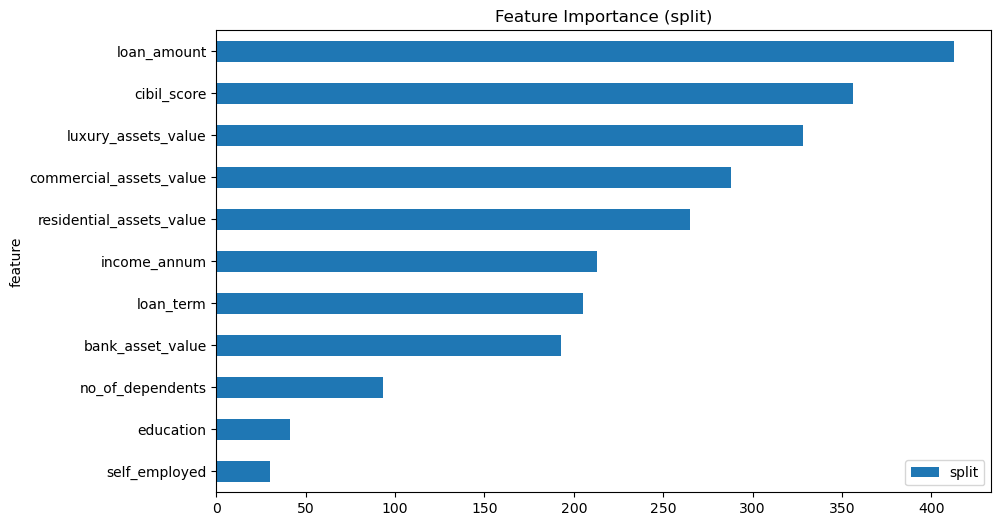

In [20]:
feature_importance_df.reset_index().sort_values("split").plot(
    kind="barh", x="feature", y="split", title="Feature Importance (split)", figsize=(10, 6)
)

<Axes: title={'center': 'Feature Importance (Gain)'}, ylabel='feature'>

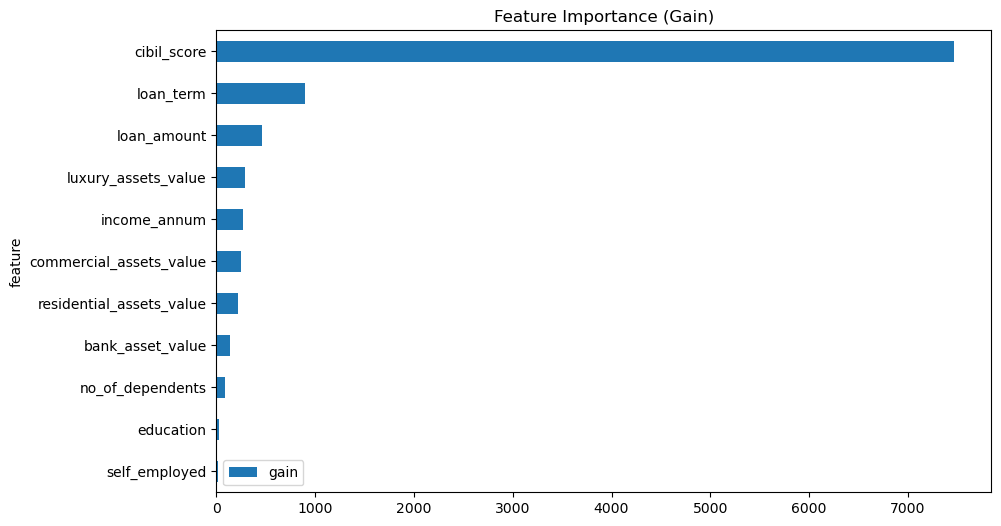

In [21]:
feature_importance_df.reset_index().sort_values("gain").plot(
    kind="barh", x="feature", y="gain", title="Feature Importance (Gain)", figsize=(10, 6)
)

In [22]:
test_preds = model.predict(df_test[train_cols])

In [23]:
evaluate_model(df_test[config.target], test_preds)



			 Evaluation
Accuracy: 1.0
F1: 0.986
Precision: 0.9778
Recall: 0.9944
ROC: 0.9915
			 Classification Report
              precision    recall  f1-score   support

           0       0.99      0.96      0.98       323
           1       0.98      0.99      0.99       531

    accuracy                           0.98       854
   macro avg       0.98      0.98      0.98       854
weighted avg       0.98      0.98      0.98       854



In [24]:
model.save_model("../model/model.txt")